In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from nats import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 60
K = 3
D = 2

## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
NUM_STATS = 1 + 2 * D
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'gibbs-tau-mu'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset_conjugate/obs.npy')).float()
STATES = torch.from_numpy(np.load('gmm_dataset_conjugate/states.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset_conjugate/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_tau(nn.Module):
    def __init__(self, num_hidden=NUM_HIDDEN1,
                       num_stats=NUM_STATS,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.tau_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        
        self.tau_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.prior_alpha = torch.ones(D) * 3
        self.prior_beta = torch.ones(D) * 3
        if CUDA:
            self.prior_alpha = self.prior_alpha.cuda()
            self.prior_beta = self.prior_beta.cuda()
        
    def forward(self, stat1, stat2, stat3):
        q = probtorch.Trace()
        stats_c1 = torch.cat((stat1[:, :, 0].unsqueeze(-1), stat2[:, :, 0, :], stat3[:, :, 0, :]), -1) ## S * B * 1+2*D
        stats_c2 = torch.cat((stat1[:, :, 1].unsqueeze(-1), stat2[:, :, 1, :], stat3[:, :, 1, :]), -1) ## S * B * 1+2*D
        stats_c3 = torch.cat((stat1[:, :, 2].unsqueeze(-1), stat2[:, :, 2, :], stat3[:, :, 2, :]), -1) ## S * B * 1+2*D
        ##
        q_alpha1 = self.tau_log_alpha(stats_c1).exp()
        q_beta1 = self.tau_log_beta(stats_c1).exp()
        q_alpha2 = self.tau_log_alpha(stats_c2).exp()
        q_beta2 = self.tau_log_beta(stats_c2).exp()
        q_alpha3 = self.tau_log_alpha(stats_c3).exp()
        q_beta3 = self.tau_log_beta(stats_c3).exp()
        ##
        q_alpha = torch.cat((q_alpha1.unsqueeze(-2), q_alpha2.unsqueeze(-2), q_alpha3.unsqueeze(-2)), -2)
        q_beta = torch.cat((q_beta1.unsqueeze(-2), q_beta2.unsqueeze(-2), q_beta3.unsqueeze(-2)), -2)
        precisions = Gamma(q_alpha, q_beta).sample()
        q.gamma(q_alpha,
                q_beta,
                value=precisions,
                name='precisions')
        
        p = probtorch.Trace()
        p.gamma(self.prior_alpha,
                self.prior_beta,
                value=q['precisions'],
                name='precisions')     
        return q, p
    
class Enc_mu(nn.Module):
    def __init__(self, num_hidden=NUM_HIDDEN1,
                       num_stats=NUM_STATS,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.mu_mu = nn.Sequential(
            nn.Linear(num_stats+D, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.mu_log_sigma = nn.Sequential(
            nn.Linear(num_stats+D, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.prior_mu = torch.zeros(D)
        self.prior_sigma = torch.ones(D) * 6.0
        if CUDA:
            self.prior_mu = self.prior_mu.cuda()
            self.prior_sigma = self.prior_sigma.cuda()

    def forward(self, stat1, stat2, stat3, tau):
        q = probtorch.Trace()
        stats_c1 = torch.cat((stat1[:, :, 0].unsqueeze(-1), stat2[:, :, 0, :], stat3[:, :, 0, :], tau[:, :, 0, :]), -1) ## S * B * 1+2*D+D
        stats_c2 = torch.cat((stat1[:, :, 1].unsqueeze(-1), stat2[:, :, 1, :], stat3[:, :, 1, :], tau[:, :, 1, :]), -1) ## S * B * 1+2*D
        stats_c3 = torch.cat((stat1[:, :, 2].unsqueeze(-1), stat2[:, :, 2, :], stat3[:, :, 2, :], tau[:, :, 2, :]), -1) ## S * B * 1+2*D
        ##
        q_mu1 = self.mu_mu(stats_c1)
        q_sigma1 = self.mu_log_sigma(stats_c1).exp()
        q_mu2 = self.mu_mu(stats_c2)
        q_sigma2 = self.mu_log_sigma(stats_c2).exp()  
        q_mu3 = self.mu_mu(stats_c3)
        q_sigma3 = self.mu_log_sigma(stats_c3).exp()     
        
        q_mu = torch.cat((q_mu1.unsqueeze(-2), q_mu2.unsqueeze(-2), q_mu3.unsqueeze(-2)), -2)
        q_sigma = torch.cat((q_sigma1.unsqueeze(-2), q_sigma2.unsqueeze(-2), q_sigma3.unsqueeze(-2)), -2)
        ##
        means = Normal(q_mu, q_sigma).sample()
        q.normal(q_mu, 
                 q_sigma, 
                 value=means, 
                 name='means')
        p = probtorch.Trace()
        p.normal(self.prior_mu, 
                 self.prior_sigma, 
                 value=q['means'], 
                 name='means')    
        return q, p
        
def initialize():
    enc_tau = Enc_tau()
    enc_mu = Enc_mu()
    if CUDA:
        enc_tau.cuda()
        enc_mu.cuda()
    optimizer =  torch.optim.Adam(list(enc_tau.parameters())+list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_tau, enc_mu, optimizer

In [8]:
def Eubo_idw(data, K, D, sample_size, batch_size):
    obs = data[:, :, :, :2]
    states = data[:, :, :, 2:]
    stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
    q_tau, p_tau = enc_tau(stat1, stat2, stat3)
    obs_tau = q_tau['precisions'].value.view(SAMPLE_SIZE, BATCH_SIZE, K, D)
    q_mu, p_mu = enc_mu(stat1, stat2, stat3, obs_tau)
    ## for individual importance weight, S * B * K
    log_q_mu = q_mu['means'].log_prob.sum(-1)
    log_q_tau = q_tau['precisions'].log_prob.sum(-1)
    log_p_mu = p_mu['means'].log_prob.sum(-1)
    log_p_tau = p_tau['precisions'].log_prob.sum(-1)

    obs_mu = q_mu['means'].value.view(SAMPLE_SIZE, BATCH_SIZE, K, D)
    obs_sigma = 1. / obs_tau.sqrt()
    ##
    labels = states.argmax(-1)
    labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
    obs_mu_expand = torch.gather(obs_mu, 2, labels_flat)
    obs_sigma_expand = torch.gather(obs_sigma, 2, labels_flat)
    log_obs = Normal(obs_mu_expand, obs_sigma_expand).log_prob(obs).sum(-1) ## S * B * N, need to group
    log_obs = torch.cat([((labels==k).float() * log_obs).sum(-1).unsqueeze(-1) for k in range(K)], -1)
    log_weights = log_obs + log_p_mu + log_p_tau - log_q_mu - log_q_tau
    weights = F.softmax(log_weights, 0).detach()
    eubo = (weights * log_weights).sum(0).sum(-1).mean()
    elbo = log_weights.sum(-1).mean()
    ess = (1. / (weights**2).sum(0)).mean(-1).mean()
    return eubo, elbo, ess, weights

In [9]:
enc_tau, enc_mu, optimizer = initialize()

In [10]:
EUBOs = []
ELBOs = []
ESSs = []



flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_ex = 0.0
    KL_in = 0.0

    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        states = STATES[batch_indices]
        data = shuffler(torch.cat((obs, states), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            data =data.cuda()
        eubo, elbo, ess, weights = Eubo_idw(data, K, D, SAMPLE_SIZE, BATCH_SIZE)
        ## KLs for mu given true sigma
        ## gradient step
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()

    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    if epoch % 10 ==0:
        time_end = time.time()
        print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-269.485, ELBO=-692.773, ESS=1.124 (6s)
epoch=10, EUBO=-235.022, ELBO=-387.810, ESS=1.276 (62s)
epoch=20, EUBO=-227.930, ELBO=-342.202, ESS=1.437 (57s)
epoch=30, EUBO=-222.900, ELBO=-311.529, ESS=1.600 (60s)
epoch=40, EUBO=-218.320, ELBO=-293.493, ESS=1.730 (62s)
epoch=50, EUBO=-216.171, ELBO=-284.766, ESS=1.807 (63s)
epoch=60, EUBO=-213.719, ELBO=-278.625, ESS=1.881 (62s)
epoch=70, EUBO=-211.691, ELBO=-273.972, ESS=1.938 (62s)
epoch=80, EUBO=-210.777, ELBO=-271.933, ESS=1.993 (55s)
epoch=90, EUBO=-210.034, ELBO=-269.371, ESS=2.035 (58s)
epoch=100, EUBO=-209.511, ELBO=-264.892, ESS=2.114 (61s)
epoch=110, EUBO=-208.963, ELBO=-260.641, ESS=2.211 (63s)
epoch=120, EUBO=-208.566, ELBO=-258.050, ESS=2.266 (62s)
epoch=130, EUBO=-208.429, ELBO=-256.557, ESS=2.330 (57s)
epoch=140, EUBO=-207.962, ELBO=-256.307, ESS=2.352 (60s)
epoch=150, EUBO=-207.652, ELBO=-254.237, ESS=2.417 (62s)
epoch=160, EUBO=-207.466, ELBO=-252.928, ESS=2.486 (60s)
epoch=170, EUBO=-207.208, ELBO=-250.899, ES

KeyboardInterrupt: 

In [12]:
torch.save(enc_tau.state_dict(), 'weights/enc-tau-%s' + PATH)
torch.save(enc_mu.state_dict(), 'weights/enc-mu-%s' + PATH)

In [13]:
def plot_results(EUBOs, ELBOs, ESSs, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')

    ax1.tick_params(labelsize=18)
    
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-240, -100])
    ax1.legend()
    ax3.legend()
    ax3.tick_params(labelsize=18)
    ax3.set_ylim([0,1])
    plt.savefig('train_' + PATH + '.svg')

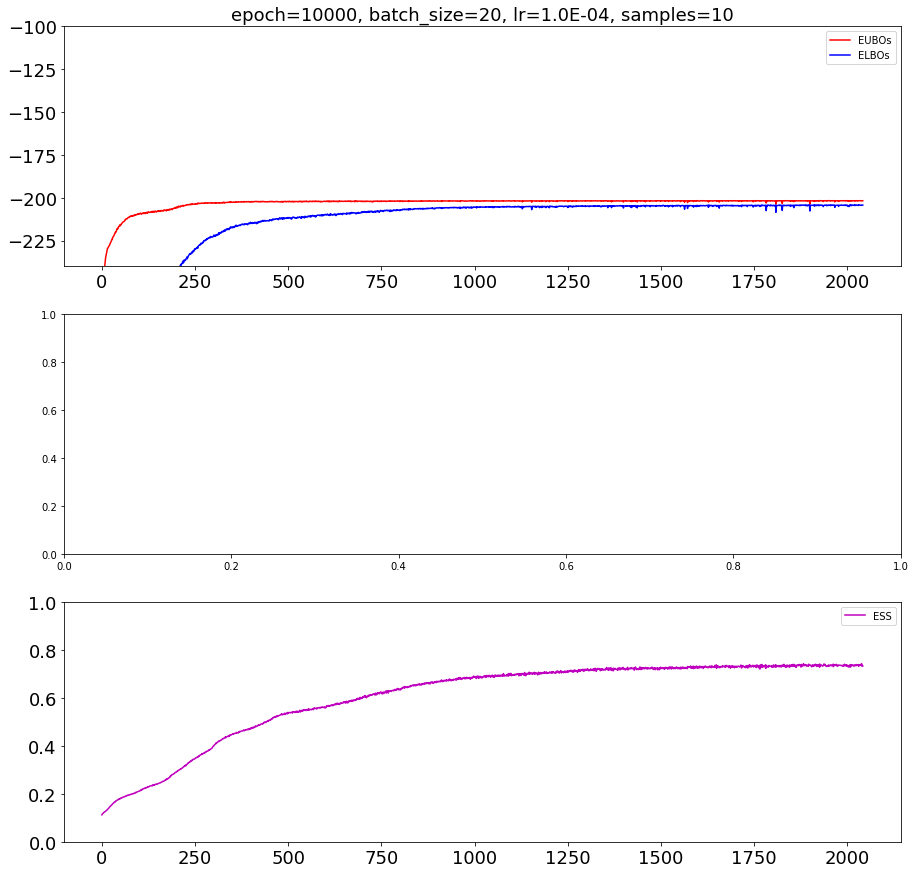

In [15]:
plot_results(EUBOs, ELBOs, ESSs, SAMPLE_SIZE, NUM_EPOCHS, LEARNING_RATE)

In [19]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    states = STATES[batch_indices]
    data = shuffler(torch.cat((obs, states), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
    if CUDA:
        obs =data.cuda()[:, :, :, :2]
        states = data.cuda()[:, :, :, 2:]
    return obs, states

obs, states = sample_single_batch(NUM_SEQS, N, K, D, batch_size=25)
stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
q_tau, p_tau = enc_tau(stat1, stat2, stat3)
obs_tau = q_tau['precisions'].value.view(SAMPLE_SIZE, 25, K, D)
q_mu, p_mu = enc_mu(stat1, stat2, stat3, obs_tau)

In [24]:
def plot_samples(obs, states, q_tau, q_mu, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,25))
    xs = obs[0].cpu()
    zs = states[0].cpu()
    mu_means = q_mu['means'].dist.loc[0].cpu().data.numpy()
    tau_means = (q_tau['precisions'].dist.concentration[0] / q_tau['precisions'].dist.rate[0]).cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b].data.numpy()
        z = zs[b].data.numpy()
        mu = mu_means[b].reshape(K, D)
        sigma2 = 1. / tau_means[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(sigma2[k]**2)
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-15, 15])
        ax.set_xlim([-15, 15])
    plt.savefig('results/modes-' + PATH + '.svg')

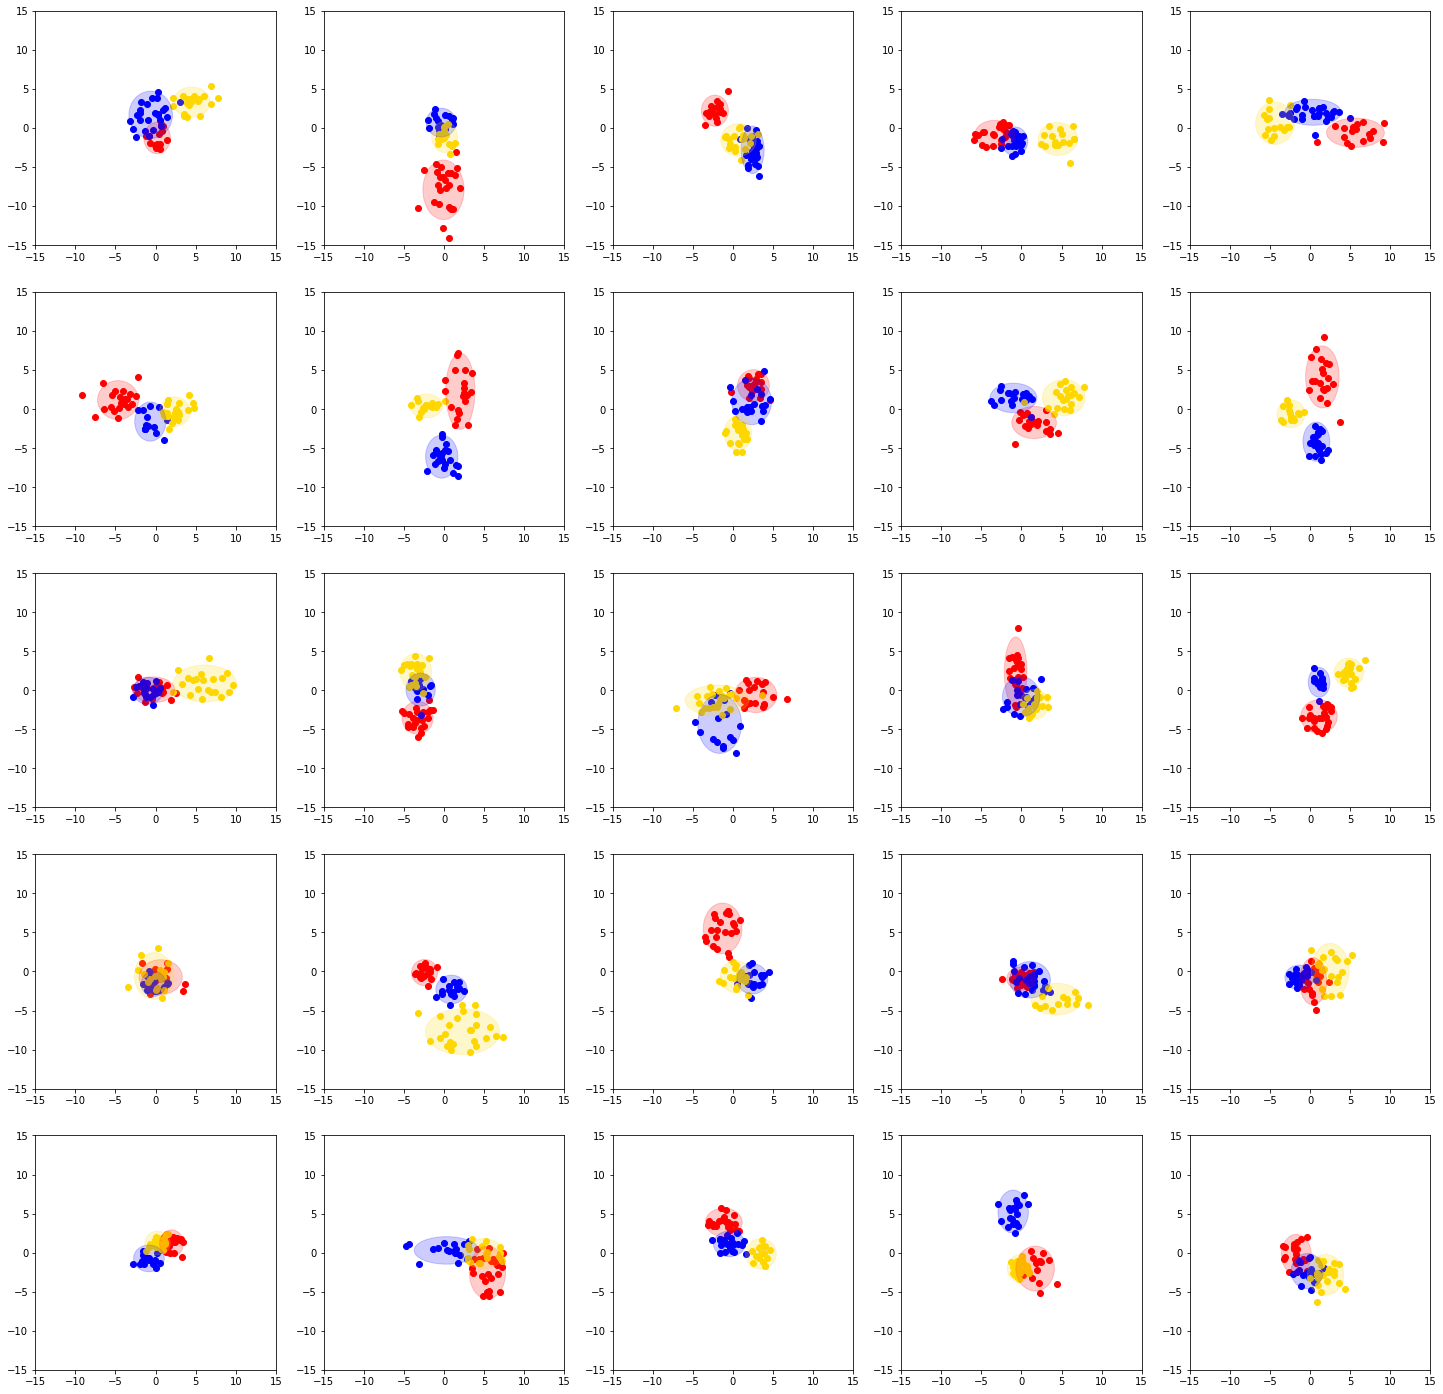

In [25]:
plot_samples(obs, states, q_tau, q_mu, batch_size=25)

In [ ]:
states[0,0].argmax(-1)